# 垃圾信分類

## 載入套件

In [1]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import re

## 讀取資料集

In [2]:
mails = pd.read_csv("./data/spam.csv", encoding="latin-1")
mails.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## 資料整理

In [3]:
mails.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1, inplace=True)
mails.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
mails.rename(columns={"v1": "label", "v2": "message"}, inplace=True)
mails.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
mails["label"].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

In [6]:
mails["label"] = mails["label"].map({"ham": 0, "spam": 1})
mails.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
# 設定停用詞
import string

stopword_list = set(stopwords.words("english") + list(string.punctuation))
# 詞形還原(Lemmatization)
lem = WordNetLemmatizer()


# 前置處理(Preprocessing)
def preprocess(text, is_lower_case=True):
    if is_lower_case:
        text = text.lower()
    tokens = word_tokenize(text)
    tokens = [token.strip() for token in tokens if len(token) > 1 and token != "..."]
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_tokens = [lem.lemmatize(token) for token in filtered_tokens]
    filtered_text = " ".join(filtered_tokens)
    return filtered_text


mails["message"] = mails["message"].map(preprocess)
mails.head()

,label,message
0,0,go jurong point crazy .. available bugis great...
1,0,ok lar joking wif oni
2,1,free entry wkly comp win fa cup final tkts 21s...
3,0,dun say early hor already say
4,0,nah n't think go usf life around though


## 文字雲

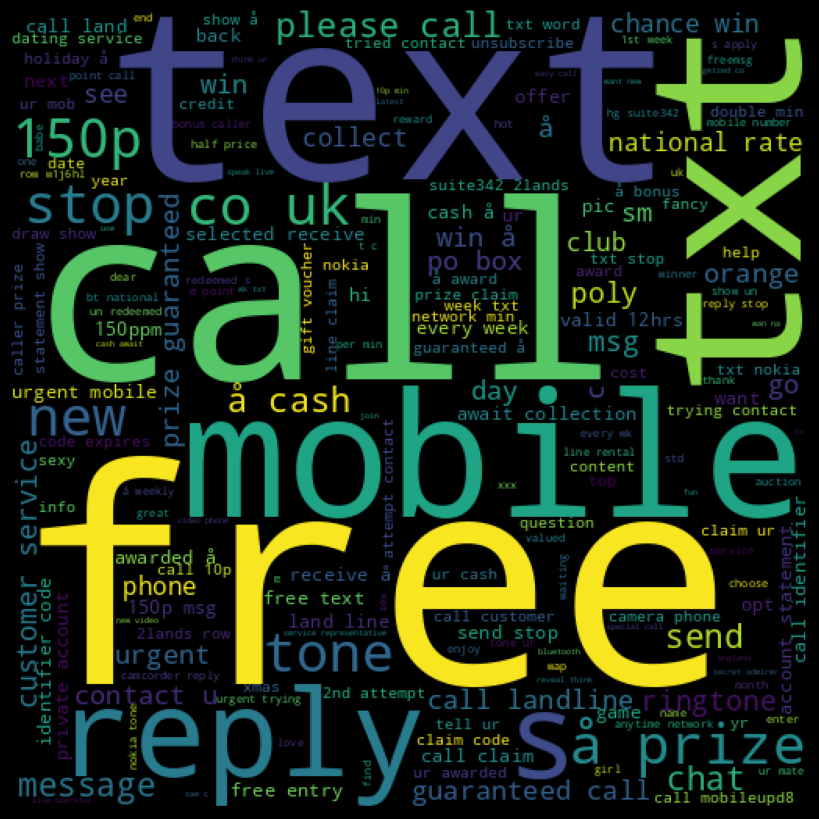

In [15]:
# 凸顯垃圾信的常用單字
spam_words = " ".join(list(mails[mails["label"] == 1]["message"]))
spam_wc = WordCloud(width=512, height=512).generate(spam_words)
plt.figure(figsize=(10, 8), facecolor="k")
plt.imshow(spam_wc)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

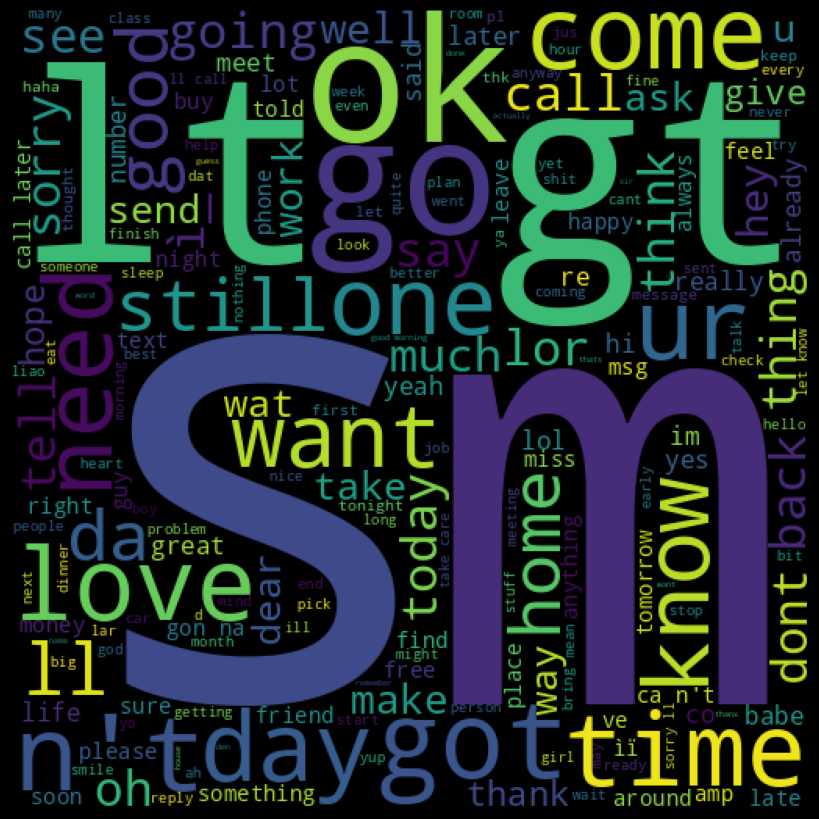

In [16]:
# 找出正常信件的常用單字
ham_words = " ".join(list(mails[mails["label"] == 0]["message"]))
ham_wc = WordCloud(width=512, height=512).generate(ham_words)
plt.figure(figsize=(10, 8), facecolor="k")
plt.imshow(ham_wc)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## 使用 SciKit-learn TF-IDF

In [17]:
mails_message, labels = mails["message"].values, mails["label"].values
mails_message = mails_message.astype(str)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(mails_message)
print(tfidf_matrix.shape)

(5572, 8117)


In [19]:
tfidf_vectorizer.get_feature_names_out()

array(['00', '000', '000pes', ..., 'ûïharry', 'ûò', 'ûówell'],
      dtype=object)

In [20]:
no = 0
for i in tfidf_matrix.toarray()[0]:
    if i > 0.0:
        no += 1
no

14

## 資料分割

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    tfidf_matrix.toarray(), labels, test_size=0.2
)

## 模型訓練

In [22]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB()

## 模型評分

In [23]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.8941704035874439

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       966
           1       0.57      0.88      0.69       149

    accuracy                           0.89      1115
   macro avg       0.77      0.89      0.81      1115
weighted avg       0.92      0.89      0.90      1115



In [25]:
confusion_matrix(y_test, y_pred)

array([[866, 100],
       [ 18, 131]])

## 測試

In [26]:
message_processed_list = (
    "I cant pick the phone right now. Pls send a message",
    "Congratulations ur awarded $500",
    "Thanks for your subscription to Ringtone UK your mobile will be charged",
    "Oops, I'll let you know when my roommate's done",
    "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, 憯1.50 to rcv",
    "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
)
X_new = tfidf_vectorizer.transform(message_processed_list)
clf.predict(X_new.toarray())

array([0, 1, 1, 0, 0, 1])